In [1]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
import time
import os
os.environ['GLOG_minloglevel'] = '2' 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore")

2024-04-29 08:14:15.137156: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 08:14:15.926066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 08:14:17.341224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

# Función para dibujar los puntos de referencia de la mano y las conexiones entre ellos
def draw_hand_landmarks(frame, landmarks, COLOR, margin=15):
    height, width = frame.shape  # Obtiene las dimensiones del frame
    x_min, y_min, x_max, y_max = width, height, 0, 0  # Inicializa los límites del rectángulo que rodea la mano

    for i, point in enumerate(landmarks.landmark):
        x, y = int(point.x * width), int(point.y * height)  # Calcula las coordenadas del punto en píxeles
        color = (0, 255, 0) if i % 4 == 0 else (0, 0, 255)  # Alterna el color entre verde y rojo para cada punto
        cv2.circle(frame, (x, y), int(height * 0.01), color, -1)  # Dibuja un círculo en el punto

        # Agregar número de punto sobre cada punto
        # cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        # Actualiza las coordenadas mínimas y máximas para dibujar un rectángulo alrededor de la mano
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x)
        y_max = max(y_max, y)

    # Definir conexiones solo para el contorno de la mano y los dedos
    connections = [[1, 2], [2, 3], [3, 4],  # Dedo pulgar
                   [5, 6], [6, 7], [7, 8],  # Dedo índice
                   [9, 10], [10, 11], [11, 12],  # Dedo medio
                   [13, 14], [14, 15], [15, 16],  # Dedo anular
                   [17, 18], [18, 19], [19, 20],  # Dedo meñique
                   [0, 1],[0, 17],[1, 5], [5, 9], [9, 13], [13, 17]]  # Conexiones de la palma de la mano

    # Dibujar las conexiones entre los puntos de referencia de la mano
    for connection in connections:
        cv2.line(frame, (int(landmarks.landmark[connection[0]].x * width), int(landmarks.landmark[connection[0]].y * height)),
                         (int(landmarks.landmark[connection[1]].x * width), int(landmarks.landmark[connection[1]].y * height)), COLOR, 2)

    # Retorna el frame con los puntos de referencia de la mano y los límites del rectángulo que rodea la mano
        # Calculate the width and height of the hand rectangle
    hand_width = x_max - x_min
    hand_height = y_max - y_min

    # Calculate the side length of the square bounding box
    square_side = max(hand_width, hand_height)

    # Calculate the coordinates of the square bounding box
    x_min_square = x_min + hand_width // 2 - square_side // 2
    x_max_square = x_min_square + square_side
    y_min_square = y_min + hand_height // 2 - square_side // 2
    y_max_square = y_min_square + square_side

    # Make sure the square bounding box is within the frame
    x_min_square = max(0, x_min_square)
    y_min_square = max(0, y_min_square)
    x_max_square = min(width, x_max_square)
    y_max_square = min(height, y_max_square)

    # Return the square bounding box instead of the hand rectangle
    return frame, (x_min_square-margin, y_min_square-margin, x_max_square+margin, y_max_square+margin)
    # return frame, (x_min-margin, y_min-margin, x_max+margin, y_max+margin)


In [9]:



# Función para capturar frames de la cámara y guardarlos en carpetas correspondientes a cada letra
def capture_frames(period, folder, num_frames):
    # Crea la carpeta principal si no existe
    if not os.path.exists(folder):
        os.makedirs(folder)

    letters = ["A", "B", "C", "D", "E", "F", "G", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U"]

    # Crea subcarpetas para cada letra del alfabeto
    for letter in letters:
        letter_folder = os.path.join(folder, letter)
        if not os.path.exists(letter_folder):
            os.makedirs(letter_folder)

    cap = cv2.VideoCapture(0)  # Inicializa la cámara
    count = 0  # Contador para capturar frames
    letter_idx = 0  # Índice de la letra actual
    frames_taken = 0  # Contador para el número de frames tomados por letra

    while True:
        ret, frame = cap.read()  # Lee un frame de la cámara

        # Si no se pudo leer el frame, termina el ciclo
        if not ret:
            print("Error al leer el frame")
            break

        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convierte el frame de BGR a RGB

        hands_results = hands.process(img)  # Procesa el frame con el modelo de manos
        black_frame = np.zeros_like(frame)  # Crea una imagen negra del mismo tamaño que el frame

        # Dibuja puntos y líneas para las manos en la imagen negra
        if hands_results.multi_hand_landmarks:
            for landmarks in hands_results.multi_hand_landmarks:
                drawn_frame, hand_rect = draw_hand_landmarks(frame, landmarks, (0, 0, 255))  # Dibuja puntos y líneas para las manos
                # Guarda el frame en la carpeta correspondiente
                if count % period == 0 and frames_taken < num_frames:
                    letter = letters[letter_idx]  # Obtiene la letra actual
                    letter_folder = os.path.join(folder, letter)  # Obtiene la carpeta correspondiente a la letra
                    try: 
                        frame_resized = cv2.resize(drawn_frame[hand_rect[1]:hand_rect[3], hand_rect[0]:hand_rect[2]], (512, 512))  # Redimensiona el frame
                        #cv2.imwrite(os.path.join(letter_folder, f"{time.time()}.jpg"), cv2.cvtColor(drawn_frame, cv2.COLOR_BGR2GRAY))  # Guarda el frame en la carpeta
                        frames_taken += 1  # Incrementa el contador de frames tomados por letra
                        count = 0  # Reinicia el contador
                    except: 
                        pass
                if frames_taken >= num_frames:
                    frames_taken = 0  # Reinicia el contador de frames tomados por letra
                    letter_idx = (letter_idx + 1) % len(letters)  # Cambia a la siguiente letra
                count += 1

        cv2.putText(frame, f'Letra: {letters[letter_idx]}, {letter_idx}', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)  # Muestra la letra actual
        cv2.putText(frame, f'Capturas: {frames_taken}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)  # Muestra el número de frames tomados
        cv2.imshow('Pose Detection', frame)  # Muestra el frame con las manos detectadas
        
        # Si se presiona la tecla 'q', termina el ciclo
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            break

    cap.release() # Liberar la cámara
    cv2.destroyAllWindows() # Cerrar todas las ventanas
    hands.close() # Cerrar el modelo de manos

# mp_hands = mp.solutions.hands # Importar el modelo de manos de MediaPipe
# hands = mp_hands.Hands() # Inicializar el modelo de manos

# capture_frames(15, "classes_poses_cut", 1) # Capturar frames cada 15 frames y guardar 100 frames por letra en la carpeta "classes_poses_cut"



In [ ]:
# crear una imagen 4x4 con plt
# fig, axs = plt.subplots(4, 4, figsize=(10, 10))
# fig.suptitle('Letras del alfabeto')
# for i, letter in enumerate(letters):
#     img = cv2.imread(f"classes_poses_cut/{letter}/0.jpg")
#     axs[i // 4, i % 4].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     axs[i // 4, i % 4].set_title(letter)
#     axs[i // 4, i % 4].axis('off')
# plt.show()


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import mediapipe as mp
import skimage.feature as skif

def preprocess_image(frame):

    fig, axs = plt.subplots(2,3, figsize=(10, 6))

    axs[0, 2].imshow(frame, cmap='gray') 
    axs[0, 2].set_title('Original')
    # Noise reduction
    frame = cv2.GaussianBlur(frame, (5, 5), 0)
    axs[0, 0].imshow(frame)
    axs[0, 0].set_title('Gaussian Blur')
    
    # Intensity normalization
    frame = cv2.normalize(frame, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    axs[0, 1].imshow(frame)
    axs[0, 1].set_title('Normalization')
    
    # Color correction (convert to grayscale)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    axs[1, 0].imshow(frame, cmap='gray')
    axs[1, 0].set_title('Grayscale')

    # Convert the image to uint8
    frame = cv2.convertScaleAbs(frame, alpha=(255.0))
    axs[1, 1].imshow(frame, cmap='gray')
    axs[1, 1].set_title('Uint8')

    plt.show()
    
    return frame

def segment_hand(frame):
    # Convert the image to HSV
    fig, axs = plt.subplots(2,3, figsize=(10, 6))
    axs[0, 0].imshow(frame)
    # agregar leyenda a cada imagen
    axs[0, 0].set_title('Original')
    frame_ = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    hsv = cv2.cvtColor(frame_, cv2.COLOR_BGR2HSV)
    axs[0, 1].imshow(hsv)
    axs[0, 1].set_title('HSV')

    # Define range for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Threshold the HSV image to get only skin colors
    mask = cv2.inRange(hsv, lower_skin, upper_skin)
    axs[0, 2].imshow(mask, cmap='gray')
    axs[0, 2].set_title('Mask')

    # # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame, frame, mask=mask)
    axs[1, 0].imshow(res, cmap='gray')
    axs[1, 0].set_title('Result')

    # Convert the result to grayscale
    # gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image
    _, thresh = cv2.threshold(res, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    axs[1, 1].imshow(thresh, cmap='gray')
    axs[1, 1].set_title('Threshold')

    # # Morphological operations
    # kernel = np.ones((3,3),np.uint8)
    # opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
    # axs[1, 1].imshow(opening, cmap='gray')

    # # Sure background area
    # sure_bg = cv2.dilate(opening, kernel, iterations=3)
    # axs[1, 2].imshow(sure_bg, cmap='gray')
    plt.show()

    # return sure_bg

def extract_features(frame):
    # Local descriptors (HOG)
    hog = skif.hog(frame, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys')
    
    # Texture features (GLCM)
    glcm = skif.greycomatrix(frame, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], normed=True, symmetric=True)
    contrast = skif.greycoprops(glcm, 'contrast')
    dissimilarity = skif.greycoprops(glcm, 'dissimilarity')
    homogeneity = skif.greycoprops(glcm, 'homogeneity')
    energy = skif.greycoprops(glcm, 'energy')
    correlation = skif.greycoprops(glcm, 'correlation')
    
    # Combine features into a single array
    features = np.hstack([hog, contrast.flatten(), dissimilarity.flatten(), homogeneity.flatten(), energy.flatten(), correlation.flatten()])
    
    return features


I0000 00:00:1714747255.475236   26649 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714747255.479044   30746 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.2-manjaro1.1), renderer: Mesa Intel(R) Xe Graphics (TGL GT2)


classes/enter/DSC00883.JPG


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


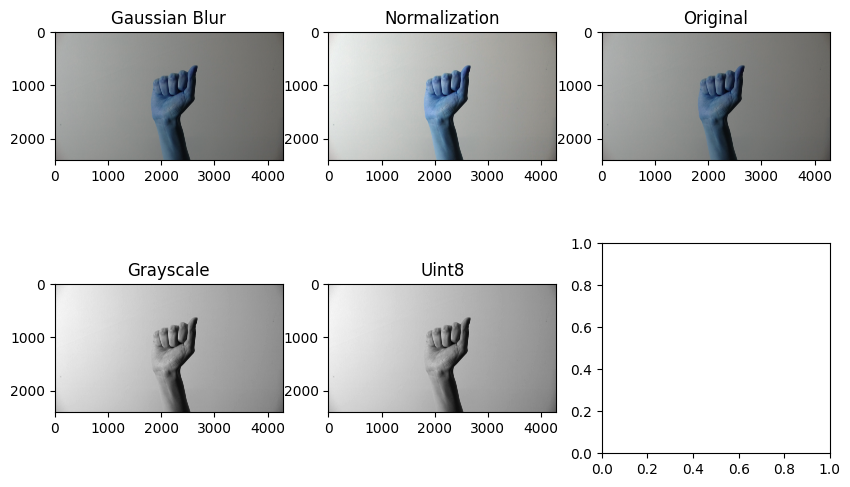

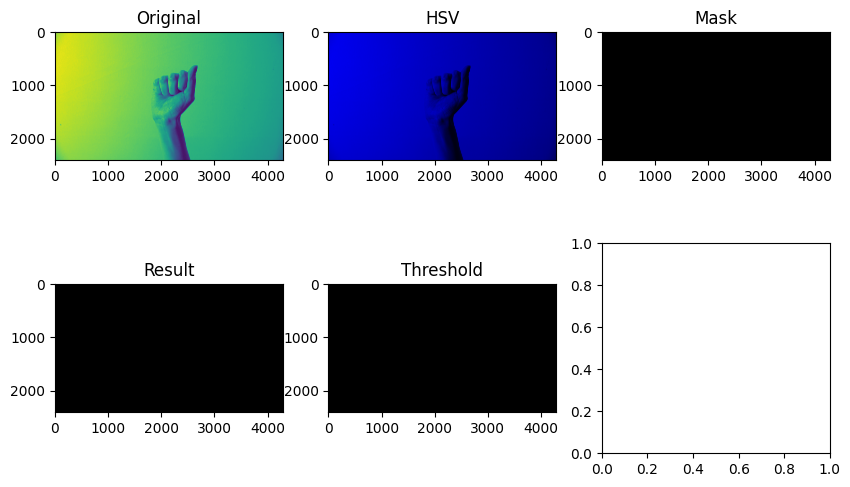

classes/enter/DSC00882.JPG


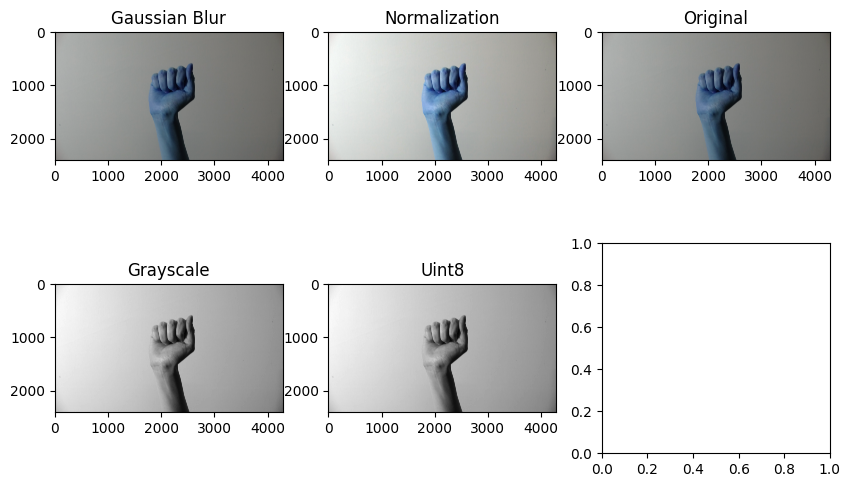

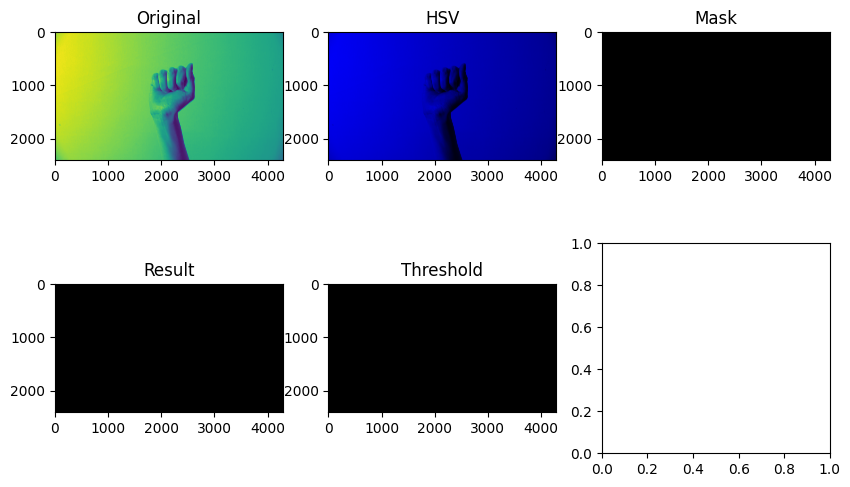

In [3]:

def process_images(directory, new_directory='classes_1'):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()

    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = subdir + os.sep + file
            new_subdir = new_directory + subdir[len(directory):]
            try: 
                os.makedirs(new_subdir, exist_ok=True)
            except Exception as e:
                print(f"Error creating directory {new_subdir}: {e}")
            
            print(filepath)
            if filepath.endswith(".JPG") or filepath.endswith(".jpg"):
                frame = cv2.imread(filepath)
                
                # Preprocessing
                frame = preprocess_image(frame)
                
                # Hand segmentation
                frame = segment_hand(frame)
                # plt.imshow(frame)
                # plt.show()
                
                # img = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
                # hands_results = hands.process(frame)
                # plt.imshow(frame)

                # if hands_results.multi_hand_landmarks:
                #     for landmarks in hands_results.multi_hand_landmarks:
                #         drawn_frame, hand_rect = draw_hand_landmarks(frame, landmarks, (0, 0, 255), 75)
                #         try: 
                #             frame_resized = cv2.resize(drawn_frame[hand_rect[1]:hand_rect[3], hand_rect[0]:hand_rect[2]], (512, 512))
                            
                #             # Feature extraction
                #             features = extract_features(frame_resized)
                            
                #             plt.imshow(frame_resized) 
                #             print(features)
                #             plt.show()  
                #             # cv2.imwrite(os.path.join(new_subdir, file), frame_resized)


                #         except Exception as e: 
                #             print(f"Error processing file {filepath}: {e}")
                
    hands.close()

process_images('classes')